# TAXI PRICE PREDICTION
## USING RIDGE/LASSO/ELASTICNET & SCALING
[![taxi](https://github.com/kevinchenkc/NYC-Taxi-Fare-Prediction-Using-Scaling/blob/main/new-york-city-tlc-taxi-stock1_2040.0.jpg?raw=True)](https://www.theverge.com/2018/8/1/17639656/uber-lyft-bailout-nyc-taxi-drivers-cap)

<hr>

## 1. Data Understanding and Data Wrangling

In [1]:
## Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Dataset source: [Kaggle](https://www.kaggle.com/code/breemen/nyc-taxi-fare-data-exploration)

In [2]:
## Import Data
df=pd.read_csv('taxi.csv')
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [3]:
## Check Missing Value
df.isna().sum()
## Result: 1 missing value on passenger_count

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      1
dtype: int64

In [4]:
## Double Check for Missing Value
df.info()
## Result: Confirmed 1 missing value on passenger_count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18919 entries, 0 to 18918
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        18919 non-null  float64
 1   pickup_datetime    18919 non-null  object 
 2   pickup_longitude   18919 non-null  float64
 3   pickup_latitude    18919 non-null  float64
 4   dropoff_longitude  18919 non-null  float64
 5   dropoff_latitude   18919 non-null  float64
 6   passenger_count    18918 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.0+ MB


In [5]:
## Handling Missing Value
df.dropna(inplace=True)


In [6]:
## Define Data Type per Column
df.dtypes
## Result: 6 out of 7 columns are numeric, only pickup_datetime is object (need to be converted into datetime type)

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [7]:
## Data Type Conversion
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])

## Confirm Conversion Result
df.dtypes
## Result: pickup_datetime column has been converted into datetime type

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count             float64
dtype: object

In [8]:
## Describe Data
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,18918.000000,18918.000000,18918.000000,18918.000000,18918.000000,18918.000000
mean,11.289221,-72.486834,39.925272,-72.498734,39.913116,1.657205
std,9.551667,10.503808,6.715228,10.461670,6.160671,1.282236
min,-3.000000,-74.438233,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992223,40.734687,-73.991233,40.734589,1.000000
50%,8.500000,-73.981758,40.752620,-73.980234,40.753566,1.000000
75%,12.500000,-73.966788,40.767427,-73.963834,40.768067,2.000000
max,180.000000,40.766125,401.083332,40.802437,41.366138,6.000000


<hr>

## 2. Data Preparation

In [9]:
## Describe columns
df.head()
## Insight: We only had information about fare amount, time, location and passenger count.
### Therefore, we need to additional features from the current feature to help us doing better analysis.

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


### 2.1 Adding Features - Features Extraction
    - Range (simplified)
    - Year
    - Month
    - Day
    - Hour

#### 2.1.1 Add Journey Range Information (pickup to dropoff)


In [10]:
## Simplified method
df['distance']=abs((df['pickup_longitude']-df['dropoff_longitude'])+(df['pickup_latitude']-df['dropoff_latitude']))
## We use absolute for this method. In a vector, there are 2 spectrums: to the right (positive) and to the left (negative)
### But absolute ignore the condition occured in vector.

In [11]:
## Drop Original Location Columns
df.drop(columns=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],inplace=True)

#### 2.1.2 Extract Time Information from Pick Up Time

In [12]:
## Assign datetime function to variable
pickup_dt=df['pickup_datetime'].dt

In [13]:
## Extract Years
df['year']=pickup_dt.year

## Extract Month
df['month']=pickup_dt.month

## Extract Day
df['day']=pickup_dt.day

## Extract Hours
df['hour']=pickup_dt.hour

## Drop Original Datetime Column
df.drop(columns='pickup_datetime',inplace=True)

### 2.2 Show updated DataFrame

In [14]:
df.head()

,fare_amount,passenger_count,distance,year,month,day,hour
0,4.5,1.0,0.006340,2009,6,15,17
1,16.9,1.0,0.107481,2010,1,5,16
2,5.7,2.0,0.019212,2011,8,18,0
3,7.7,1.0,0.020512,2012,4,21,4
4,5.3,1.0,0.027194,2010,3,9,7


<hr>

## 3. Machine Learning

### 3.1 Splitting Data

In [15]:
## Import package
from sklearn.model_selection import train_test_split

In [16]:
## Define features and target
x=df.drop(columns='fare_amount')
y=df['fare_amount']

In [17]:
## Split Data with proportion of 85% train : 15% test
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.15,random_state=42)

### 3.2 Machine Learning Modelling

In [18]:
## Import package
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#### 3.2.1 Build Model

In [19]:
## Build Base Model
Model_LR=LinearRegression(fit_intercept=False) # when all features have value of 0, price (target) must be 0 too -> no transactions
Model_R=Ridge()
Model_L=Lasso()
Model_E=ElasticNet()

In [20]:
# Learning Model -> finding pattern from question-answer of Training Data
Model_LR.fit(x_train,y_train)
Model_R.fit(x_train,y_train)
Model_L.fit(x_train,y_train)
Model_E.fit(x_train,y_train)

ElasticNet()

In [21]:
## Predicted Target
pred_test_LR=Model_LR.predict(x_test)
pred_test_R=Model_R.predict(x_test)
pred_test_L=Model_L.predict(x_test)
pred_test_E=Model_E.predict(x_test)

#### 3.2.2 Training Model

In [22]:
## Describe shape of train features
x_train.shape

(16080, 6)

In [23]:
## Show train features
x_train.head()

,passenger_count,distance,year,month,day,hour
2760,3.0,0.038267,2014,11,5,0
13436,1.0,0.076557,2015,1,8,11
5746,1.0,0.016469,2011,10,2,10
5998,1.0,0.062633,2014,12,21,22
6896,6.0,0.018300,2014,9,3,17


In [24]:
## Convert train features to DataFrame
df_x_train=pd.DataFrame(x_train)
df_x_train.head()

,passenger_count,distance,year,month,day,hour
2760,3.0,0.038267,2014,11,5,0
13436,1.0,0.076557,2015,1,8,11
5746,1.0,0.016469,2011,10,2,10
5998,1.0,0.062633,2014,12,21,22
6896,6.0,0.018300,2014,9,3,17


#### 3.2.3 Testing Model

In [25]:
## Describe shape of test features
x_test.shape

(2838, 6)

In [26]:
## Show test features
x_test.head()

,passenger_count,distance,year,month,day,hour
12565,1.0,0.034270,2012,6,15,9
5282,1.0,0.013032,2012,1,19,18
4525,2.0,0.058549,2010,11,16,19
17370,2.0,0.069345,2011,2,9,14
9239,1.0,0.013675,2013,10,7,21


In [27]:
## Convert test features to DataFrame
df_x_test=pd.DataFrame(x_test)
df_x_test.head()

,passenger_count,distance,year,month,day,hour
12565,1.0,0.034270,2012,6,15,9
5282,1.0,0.013032,2012,1,19,18
4525,2.0,0.058549,2010,11,16,19
17370,2.0,0.069345,2011,2,9,14
9239,1.0,0.013675,2013,10,7,21


#### 3.2.4 Prediction with Training and Testing Model

In [28]:
## Predict with every Model
LR_train=Model_LR.predict(df_x_train)
LR_test=Model_LR.predict(df_x_test)

R_train=Model_R.predict(df_x_train)
R_test=Model_R.predict(df_x_test)

L_train=Model_L.predict(df_x_train)
L_test=Model_L.predict(df_x_test)

E_train=Model_E.predict(df_x_train)
E_test=Model_E.predict(df_x_test)

### 3.3 Evaluation Matrix

#### 3.3.1 Check and Compare Evaluation Matrix Score for each Models

In [29]:
## Create function for evaluation matrix
def Eva_Matrix(Model,x,y_true):
    y_pred=Model.predict(x)
    R2=r2_score(y_true,y_pred)
    MAE=mean_absolute_error(y_true,y_pred)
    MSE=mean_squared_error(y_true,y_pred)
    RMSE=np.sqrt(MSE)
    return R2,MAE,MSE,RMSE

In [30]:
## Linear Regression Training
r2_LR_Train,MAE_LR_Train,MSE_LR_Train,RMSE_LR_Train=Eva_Matrix(Model_LR,x_train,y_train)
## Linear Regression Testing
r2_LR_Test,MAE_LR_Test,MSE_LR_Test,RMSE_LR_Test=Eva_Matrix(Model_LR,x_test,y_test)
## Ridge Training
r2_Ridge_Train,MAE_Ridge_Train,MSE_Ridge_Train,RMSE_Ridge_Train=Eva_Matrix(Model_R,x_train,y_train)
## Ridge Testing
r2_Ridge_Test,MAE_Ridge_Test,MSE_Ridge_Test,RMSE_Ridge_Test=Eva_Matrix(Model_R,x_test,y_test)
## Lasso Training
r2_Lasso_Train,MAE_Lasso_Train,MSE_Lasso_Train,RMSE_Lasso_Train=Eva_Matrix(Model_L,x_train,y_train)
## Lasso Testing
r2_Lasso_Test,MAE_Lasso_Test,MSE_Lasso_Test,RMSE_Lasso_Test=Eva_Matrix(Model_L,x_test,y_test)
## ElasticNet Training
r2_Elasticnet_Train,MAE_Elasticnet_Train,MSE_Elasticnet_Train,RMSE_Elasticnet_Train=Eva_Matrix(Model_E,x_train,y_train)
## ElasticNet Testing
r2_Elasticnet_Train,MAE_Elasticnet_Train,MSE_Elasticnet_Train,RMSE_Elasticnet_Train=Eva_Matrix(Model_E,x_test,y_test)

In [31]:
## EVALUATION MATRIX COMPARISON
eva_matrix={
    'Linear Regression Training':[r2_LR_Train,MAE_LR_Train,MSE_LR_Train,RMSE_LR_Train],
    'Linear Regression Testing':[r2_LR_Test,MAE_LR_Test,MSE_LR_Test,RMSE_LR_Test],
    'Ridge Training':[r2_Ridge_Train,MAE_Ridge_Train,MSE_Ridge_Train,RMSE_Ridge_Train],
    'Ridge Testing':[r2_Ridge_Test,MAE_Ridge_Test,MSE_Ridge_Test,RMSE_Ridge_Test],
    'Lasso Training':[r2_Lasso_Train,MAE_Lasso_Train,MSE_Lasso_Train,RMSE_Lasso_Train],
    'Lasso Testing':[r2_Lasso_Test,MAE_Lasso_Test,MSE_Lasso_Test,RMSE_Lasso_Test],
    'Elasticnet Training':[r2_Elasticnet_Train,MAE_Elasticnet_Train,MSE_Elasticnet_Train,RMSE_Elasticnet_Train],
    'Elasticnet Testing':[r2_Elasticnet_Train,MAE_Elasticnet_Train,MSE_Elasticnet_Train,RMSE_Elasticnet_Train],    
    'Range':['-~ to 1','0 to ~','0 to ~','0 to ~'],
    'Indicator':['Closer to 1 the better','Closer to 0 the better','Closer to 0 the better','Closer to 0 the better']
}
summary=pd.DataFrame(eva_matrix,index=['R-Squared','MAE','MSE','RMSE']).round(4)
summary.T

,R-Squared,MAE,MSE,RMSE
Linear Regression Training,0.0021,6.0125,92.1261,9.5982
Linear Regression Testing,0.0031,5.7447,84.6864,9.2025
Ridge Training,0.016,5.9428,90.8448,9.5313
Ridge Testing,0.0172,5.6783,83.4897,9.1373
Lasso Training,0.011,5.9701,91.3031,9.5553
Lasso Testing,0.0099,5.7036,84.1093,9.1711
Elasticnet Training,0.014,5.6895,83.7559,9.1518
Elasticnet Testing,0.014,5.6895,83.7559,9.1518
Range,-~ to 1,0 to ~,0 to ~,0 to ~
Indicator,Closer to 1 the better,Closer to 0 the better,Closer to 0 the better,Closer to 0 the better


Insight:
- Based on R-Squared score, all models are not an ideal models since both training and testing models only produce score below 0.02. Good model should produce R-Squared score above 0.80.
- Other evaluation parameters such as MAE, MSE, RMSE also score nowhere near 0 (ideal score).
- Improvement is necessary for all models.

<hr>

## 4 Machine Learning Improvement

### 4.1 Using Feature Engineering (Polynomial Transformer)

In [32]:
## Import package
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
## Power transformer enable to use float as powers of numbers (Bahasa Indonesia: pangkat)

In [45]:
## Create model with Polynomial Features
poly=PolynomialFeatures(degree=3,include_bias=False)

In [34]:
## Create model with Power Transformer
yeo_pow=PowerTransformer('yeo-johnson')

In [35]:
## Show data
df.head()
## Analysis: we want to do scaling, 
### Exclude features with limited value such as hour (limited to 24 hours), month (limited to 12 months), and day (limited to 28-31 days)

,fare_amount,passenger_count,distance,year,month,day,hour
0,4.5,1.0,0.006340,2009,6,15,17
1,16.9,1.0,0.107481,2010,1,5,16
2,5.7,2.0,0.019212,2011,8,18,0
3,7.7,1.0,0.020512,2012,4,21,4
4,5.3,1.0,0.027194,2010,3,9,7


In [36]:
## Extract columns/features we would like to transform
num_col=df[['passenger_count','distance','year']]

In [50]:
## Fit and Transform to Model
num_poly=poly.fit_transform(num_col)
num_pow=yeo_pow.fit_transform(num_poly) # Result as array

In [51]:
## Transform Array to DataFrame
df_pow=pd.DataFrame(num_pow)
df_pow.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.541042,-1.053236,-1.930678e-13,-0.600677,-1.081936,-0.514831,-0.495979,-0.882452,-1.869616e-13,-0.623728,-0.941961,-0.513990,-0.538653,-0.983503,-0.518532,-0.197541,-1.184868,-0.717414,4.227729e-13
1,-0.541042,1.878846,-1.273981e-13,-0.600677,1.278273,-0.514100,1.767568,1.333108,-1.860734e-13,-0.623728,0.626139,-0.513574,1.257450,0.956526,-0.517123,0.506135,1.663864,1.212546,4.263256e-13
2,0.914194,-0.377609,-6.183942e-14,1.185880,0.003999,0.577272,-0.420281,-0.076170,-1.852962e-13,1.262003,0.270707,0.646762,-0.409884,0.200604,0.557731,-0.193578,-0.382919,-0.073011,4.298784e-13
3,-0.541042,-0.316858,3.552714e-15,-0.600677,-0.547070,-0.512641,-0.408462,-0.025478,-1.845191e-13,-0.623728,-0.641979,-0.512742,-0.468091,-0.233355,-0.514305,-0.192686,-0.298870,-0.030280,4.333200e-13
4,-0.541042,-0.023812,-1.273981e-13,-0.600677,-0.326710,-0.514100,-0.335893,0.193551,-1.860734e-13,-0.623728,-0.511800,-0.513574,-0.409645,-0.041577,-0.517123,-0.186034,0.091814,0.155342,4.263256e-13


In [52]:
## Combine original features and transformed features
df_1=pd.concat([df.drop(columns=['passenger_count','distance','year']),df_pow],axis=1)
df_1.head()

,fare_amount,month,day,hour,0,1,2,3,4,5,...,9,10,11,12,13,14,15,16,17,18
0,4.5,6,15,17,-0.541042,-1.053236,-1.930678e-13,-0.600677,-1.081936,-0.514831,...,-0.623728,-0.941961,-0.513990,-0.538653,-0.983503,-0.518532,-0.197541,-1.184868,-0.717414,4.227729e-13
1,16.9,1,5,16,-0.541042,1.878846,-1.273981e-13,-0.600677,1.278273,-0.514100,...,-0.623728,0.626139,-0.513574,1.257450,0.956526,-0.517123,0.506135,1.663864,1.212546,4.263256e-13
2,5.7,8,18,0,0.914194,-0.377609,-6.183942e-14,1.185880,0.003999,0.577272,...,1.262003,0.270707,0.646762,-0.409884,0.200604,0.557731,-0.193578,-0.382919,-0.073011,4.298784e-13
3,7.7,4,21,4,-0.541042,-0.316858,3.552714e-15,-0.600677,-0.547070,-0.512641,...,-0.623728,-0.641979,-0.512742,-0.468091,-0.233355,-0.514305,-0.192686,-0.298870,-0.030280,4.333200e-13
4,5.3,3,9,7,-0.541042,-0.023812,-1.273981e-13,-0.600677,-0.326710,-0.514100,...,-0.623728,-0.511800,-0.513574,-0.409645,-0.041577,-0.517123,-0.186034,0.091814,0.155342,4.263256e-13


In [53]:
## Define features and target
x_1=df_1.drop(columns='fare_amount')
y_1=df_1['fare_amount']

In [54]:
## Split Data
x_train_1,x_test_1,y_train_1,y_test_1=train_test_split(x_1,y_1,train_size=.85,random_state=42)

In [56]:
## Build Function to automatically print Evaluation Matrix Score
def Eva_Matrix_Base(model,x_train, x_test, y_train, y_test, Nama):
    Model = model.fit(x_train, y_train)
    y_pred_tr = Model.predict(x_train)
    R2_train = r2_score(y_train, y_pred_tr)
    MAE_train = mean_absolute_error(y_train, y_pred_tr)
    MSE_train = mean_squared_error(y_train, y_pred_tr)
    RMSE_train = np.sqrt(MSE_train)
    y_pred_ts = Model.predict(x_test)
    R2_test = r2_score(y_test, y_pred_ts)
    MAE_test = mean_absolute_error(y_test, y_pred_ts)
    MSE_test = mean_squared_error(y_test, y_pred_ts)
    RMSE_test = np.sqrt(MSE_test)
    eva_data = {
    "Training" + Nama : [R2_train, MAE_train, MSE_train, RMSE_train],
    "Testing" + Nama : [R2_test, MAE_test, MSE_test, RMSE_test],
    }
    df = pd.DataFrame(eva_data, index=['R2', 'MAE', 'MSE', 'RMSE'])
    
    return Model, df

In [61]:
## Build Model
model, df_LinReg2 = Eva_Matrix_Base(LinearRegression(fit_intercept=False),
                            x_train_1, x_test_1, y_train_1, y_test_1,
                            "LinReg 2")
df_LinReg2.round(2)

,TrainingLinReg 2,TestingLinReg 2
R2,0.50,0.51
MAE,3.58,3.44
MSE,46.28,41.34
RMSE,6.80,6.43


### 4.2 Using Feature Engineering + Others Algorithm

In [60]:
## Using Ridge
model_R, df_Ridge2 = Eva_Matrix_Base(Ridge(), x_train_1, x_test_1, y_train_1, y_test_1, "Ridge")
df_Ridge2.round(2)

,TrainingRidge,TestingRidge
R2,0.49,0.50
MAE,3.64,3.52
MSE,47.44,42.62
RMSE,6.89,6.53


In [62]:
## Using Lasso
model_L, df_Lasso2 = Eva_Matrix_Base(Lasso(), x_train_1, x_test_1, y_train_1, y_test_1, "Lasso")
df_Lasso2.round(2)

,TrainingLasso,TestingLasso
R2,0.42,0.43
MAE,3.90,3.74
MSE,53.67,48.31
RMSE,7.33,6.95


In [64]:
## Using ElasticNet
model_E, df_Enet2 = Eva_Matrix_Base(ElasticNet(), x_train_1, x_test_1, y_train_1, y_test_1, "Enet")
df_Enet2.round(2)

,TrainingEnet,TestingEnet
R2,0.41,0.42
MAE,3.98,3.82
MSE,54.49,49.42
RMSE,7.38,7.03


In [65]:
pd.concat([df_LinReg2, df_Ridge2, df_Lasso2, df_Enet2], axis=1).T.round(2)

,R2,MAE,MSE,RMSE
TrainingLinReg 2,0.50,3.58,46.28,6.80
TestingLinReg 2,0.51,3.44,41.34,6.43
TrainingRidge,0.49,3.64,47.44,6.89
TestingRidge,0.50,3.52,42.62,6.53
TrainingLasso,0.42,3.90,53.67,7.33
TestingLasso,0.43,3.74,48.31,6.95
TrainingEnet,0.41,3.98,54.49,7.38
TestingEnet,0.42,3.82,49.42,7.03


### 4.3 Using Manual Tuning

In [66]:
## Determine alpha(s)
Alpha = np.arange(0, 0.2, 0.0001)

In [67]:
## Build function to store train and test R-Squared score for visualization
def Manual_Tune(Alpha, x_train, x_test, y_train, y_test, Model):
    train_r = []
    test_r = []
    
    for i in Alpha:
        model_R = Model(alpha=i)
        model_R.fit(x_train, y_train)
        y_pred_tr = model_R.predict(x_train)
        R2_train = r2_score(y_train, y_pred_tr)
        train_r.append(R2_train)
        y_pred_ts = model_R.predict(x_test)
        R2_test = r2_score(y_test, y_pred_ts)
        test_r.append(R2_test)
    return train_r, test_r

In [69]:
## Run function for Ridge
train_ridge, test_ridge = Manual_Tune(Alpha, x_train_1, x_test_1, y_train_1, y_test_1, Ridge)

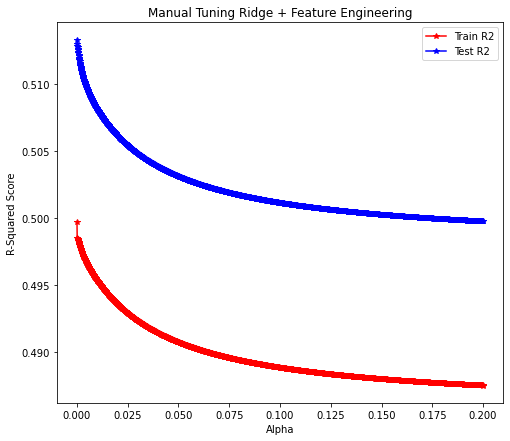

In [70]:
## Ridge Manual Tuning Visualization
plt.figure(figsize=(8,7))
plt.plot(Alpha, train_ridge, 'r*-')
plt.plot(Alpha, test_ridge, 'b*-')
plt.legend(['Train R2', 'Test R2'])
plt.title("Manual Tuning Ridge + Feature Engineering")
plt.xlabel("Alpha")
plt.ylabel("R-Squared Score")
plt.show()

In [71]:
## Run function for Lasso
train_Lasso, test_Lasso = Manual_Tune(Alpha, x_train_1, x_test_1, y_train_1, y_test_1, Lasso)

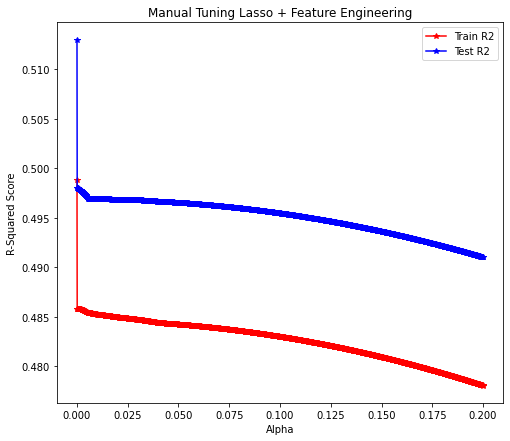

In [73]:
## Lasso Manual Tuning Visualization
plt.figure(figsize=(8,7))
plt.plot(Alpha, train_Lasso, 'r*-')
plt.plot(Alpha, test_Lasso, 'b*-')
plt.legend(['Train R2', 'Test R2'])
plt.title("Manual Tuning Lasso + Feature Engineering")
plt.xlabel("Alpha")
plt.ylabel("R-Squared Score")
plt.show()

In [74]:
## Determine new alpha(s) for ElasticNet
beta = np.arange(0, 5, 0.001)

In [75]:
## Run function for ElasticNet using beta
train_Enet, test_Enet = Manual_Tune(beta, x_train_1, x_test_1, y_train_1, y_test_1, ElasticNet)

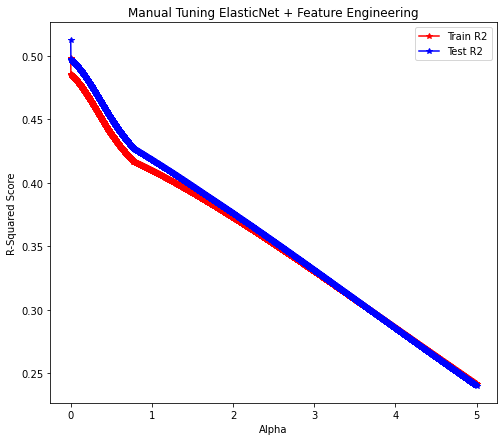

In [76]:
plt.figure(figsize=(8,7))
plt.plot(beta, train_Enet, 'r*-')
plt.plot(beta, test_Enet, 'b*-')
plt.legend(['Train R2', 'Test R2'])
plt.title("Manual Tuning ElasticNet + Feature Engineering")
plt.xlabel("Alpha")
plt.ylabel("R-Squared Score")
plt.show()

In [77]:
print('Max R-Squared score for Ridge: ',np.max(test_ridge))
print('Max R-Squared score for Lasso: ',np.max(test_Lasso))
print('Max R-Squared score for ElasticNet: ',np.max(test_Enet))

Max R-Squared score for Ridge:  0.5132790584123553
Max R-Squared score for Lasso:  0.5129769184571487
Max R-Squared score for ElasticNet:  0.5129769184571487


<hr>

## Error Analysis

In [78]:
## Copy train features
df_Error_T = x_train_1.copy()

In [79]:
## Show train features
df_Error_T.head()

,month,day,hour,0,1,2,3,4,5,6,...,9,10,11,12,13,14,15,16,17,18
2760,11,5,0,1.486464,0.398102,1.339484e-13,1.621540,1.361174,1.290893,-0.173363,...,1.650726,1.836283,1.326778,0.219215,1.008321,1.284311,-0.165234,0.585840,0.397484,4.403145e-13
13436,1,8,11,-0.541042,1.402966,1.990075e-13,-0.600677,0.836347,-0.510453,0.742482,...,-0.623728,0.266931,-0.511496,0.451858,0.702968,-0.510080,0.060335,1.399278,0.931242,4.438672e-13
5746,10,2,10,-0.541042,-0.510040,-6.183942e-14,-0.600677,-0.689840,-0.513370,-0.442731,...,-0.623728,-0.724143,-0.513158,-0.495711,-0.380397,-0.515713,-0.195099,-0.564949,-0.170137,4.298784e-13
5998,12,21,22,-0.541042,1.104164,1.339484e-13,-0.600677,0.576665,-0.511182,0.353108,...,-0.623728,0.076120,-0.511911,0.142354,0.554207,-0.511488,-0.055877,1.200967,0.769368,4.403145e-13
6896,9,3,17,2.048708,-0.420993,1.339484e-13,1.850170,1.305313,2.646804,-0.428121,...,1.821082,2.155690,2.487433,-0.182675,0.974306,2.703028,-0.194136,-0.441866,-0.102070,4.403145e-13


In [80]:
## Add train target as new column
df_Error_T['target'] = y_train_1

In [81]:
## Determine best Alpha from Manual Tuning
best_a = Alpha[np.argmax(test_ridge)]

In [82]:
## Build new Model with best Alpha from Manual Tuning
Model_R = Ridge(alpha=best_a)

In [83]:
## Fit Model
Model_R.fit(x_train_1, y_train_1)

Ridge(alpha=0.0)

In [84]:
## Predict with new Model
pred_train = Model_R.predict(x_train_1)

In [85]:
## Add prediction result as new column
df_Error_T['prediction'] = pred_train

In [87]:
## Add Error Column from difference between actual and predicted target
df_Error_T['Error'] = abs(df_Error_T['target'] - df_Error_T['prediction'])

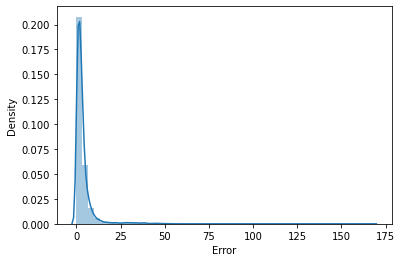

In [88]:
## Visualization with Histogram to determine distribution of error
sns.distplot(df_Error_T['Error'])
plt.show()

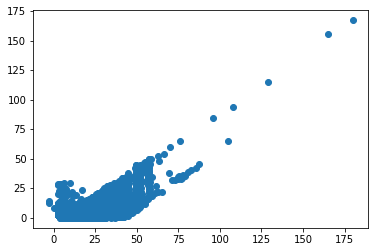

In [89]:
## Visualization with Scatterplot to determine relationship of actual target and error
plt.scatter(df_Error_T['target'], df_Error_T['Error'])
plt.show()